In [2]:
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import json
from matplotlib_venn import venn2_unweighted, venn3_unweighted
from matplotlib import pyplot as plt
from rich.progress import track
from scipy import stats

In [18]:
def compare(table, columns):
    t = table.select(columns).drop_null()
    a = t[columns[0]].to_numpy()
    b = t[columns[1]].to_numpy()
    rho = stats.spearmanr(a, b).statistic
    tau = stats.kendalltau(a, b).statistic
    print(f"Kendall's Tau: {tau}\tSpearman's Rho: {rho}")

table = pq.read_table("../src/masskit/apps/process/libraries/pubchem_links.parquet")

print("Wikipedia vs. PubMed:", end='\t')
compare(table, ['average_pageviews','pmid_count_distinct'])
print("Wikipedia vs. Patent:", end='\t')
compare(table, ['average_pageviews','patent_id_count'])
print("PubMed vs. Patent:", end='\t')
compare(table, ['pmid_count_distinct','patent_id_count'])



Wikipedia vs. PubMed:	Kendall's Tau: 0.4712626777420114	Spearman's Rho: 0.6502205106043585
Wikipedia vs. Patent:	Kendall's Tau: 0.31964167798783727	Spearman's Rho: 0.46177778989783125
PubMed vs. Patent:	Kendall's Tau: 0.34780381029102414	Spearman's Rho: 0.4874942129799655


In [3]:
#!cd
!python ../src/masskit/apps/process/libraries/pubchem_links.py

Attempting to find or download data files:
Using cache file C:\Users\slottad\.masskit_cache\pubchem\pubchem-wiki.json
Using cache file C:\Users\slottad\.masskit_cache\pubchem\cid-wikipedia.parquet
Using cache file C:\Users\slottad\.masskit_cache\pubchem\CID-InChI-Key.gz
Using cache file C:\Users\slottad\.masskit_cache\pubchem\CID-Patent.gz
Using cache file C:\Users\slottad\.masskit_cache\pubchem\CID-PMID.gz


In [3]:
# Load NIST Library data files
nist_files = [
    '~/data/nist/ei/2023/old/main_2023.parquet',
    '~/data/nist/ei/2023/old/rep_2023.parquet',
    '~/data/nist/ei/2023/old/ri_2023.parquet',
    '~/data/nist/tandem/2023/old/apci_msms_2023.parquet',
    '~/data/nist/tandem/2023/old/hr_msms_2023.parquet',
    '~/data/nist/tandem/2023/old/lr_msms_2023.parquet'
]
tables = []
for file in nist_files:
    table = pq.read_table(file, columns=['id', 'name', 'inchi_key', 'inchi_key_orig'])
    tables.append(table)
tables

[pyarrow.Table
 id: uint64
 name: string
 inchi_key: string
 inchi_key_orig: string
 ----
 id: [[1,2,3,4,5,...,4997,4998,4999,5000,5001],[5002,5003,5004,5005,5006,...,9997,9998,9999,10000,10001],...,[340009,340010,340011,340012,340013,...,345004,345005,345006,345007,345008],[345009,345010,345011,345012,345013,...,347101,347102,347103,347104,347105]]
 name: [["Hydrogen","Deuterium","Diazirine","Methane, diazo-","Ketene",...,"Pentafluoropropionamide, N-allyl-N-(3-methylbutyl)-","5-Bromo-2-cyclopentylamino-3-nitropyridine","4H-1-Benzopyran-4-one, 5-hydroxy-2-methyl-7-(2-propenyloxy)-","3,4'-Dimethyl-2,3'-dioxobicyclohexyl-5-ene-3,4'-dicarboxylic acid, dimethyl ester","Eudesma-4(14),7(11)-dien-8-one"],["2-Diallylamino-N-phenyl-2-thioxo-acetamide","Allyl-(4,6-di-piperidin-1-yl-[1,3,5]triazin-2-yl)-amine","Cyclopropanecarboxamide, N-[7-(cyclopropylcarbonyl)-2,3-dihydro-1,4-benzodioxin-6-yl]-","Acetamide, 2-(cyclohexylamino)-N-(5,6,7,8-tetrahydro-2-methyl-4-oxo[1]benzothieno[2,3-d]pyrimidin-3

In [4]:
# Get the set of INCHI Keys from the NIST Libraries
inchi_keys = pa.concat_arrays( [ i.column("inchi_key").combine_chunks() for i in tables ] )
inchi_keys_orig = pa.concat_arrays( [ i.column("inchi_key_orig").combine_chunks() for i in tables ] )

# Use a filter to find which keys don't match
#inchi_ne = (pc.not_equal(pc.field("inchi_key"), pc.field("inchi_key_orig")))
#inchi_ne = (pc.field("inchi_key") != pc.field("inchi_key_orig"))
#inchi_ne
#tables[0].filter(inchi_ne).shape

# Find the full set of keys
ik_set = set(inchi_keys.unique().to_pylist())
ik_orig_set = set(inchi_keys_orig.unique().to_pylist())
ik_full_set = ik_set | ik_orig_set

In [5]:
# Find the overlapping set with PubChem
cid2inchi_full = pq.read_table('~/.masskit_cache/pubchem/cid-inchi.parquet', columns=['cid', 'inchi_key'])
table2 = pa.table({'inchi_key': ik_full_set})
cid2inchi = cid2inchi_full.join(table2,keys='inchi_key',join_type='inner')
pubchem_inchi = set(cid2inchi['inchi_key'].to_pylist())
cid2inchi_full.num_rows

115078430

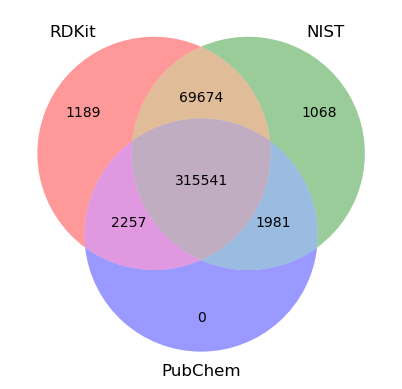

In [6]:
# Show overlaps
venn3_unweighted([ik_set,ik_orig_set, pubchem_inchi],set_labels=("RDKit","NIST", "PubChem"))

In [8]:
cid2inchi

pyarrow.Table
cid: int64
inchi_key: string
----
cid: [[478049,478572,478577,478592,478811,...,91732524,91732525,91732526,91732527,91732528],[555320,555327,555329,555330,555332,...,165365255,165365256,165365257,165366762,166530468],...,[518275,518310,518325,518457,518459,...,168006556,168007633,163750808,163753121,163770541],[1851236,1851527,1852292,1853048,1854043,...,162986289,162986517,164845047,166444301,167563521]]
inchi_key: [["KDPBLDOVCGAWNQ-UHFFFAOYSA-N","INPHXCCBDRGBRF-UHFFFAOYSA-N","DSZRZFCUYHAAAE-UHFFFAOYSA-N","QZEAJJHJTPPDMU-UHFFFAOYSA-N","UGZDFLLCOFLFNY-UHFFFAOYSA-N",...,"DVUCLMCSYZFBOY-UHFFFAOYSA-N","FFVOYKANDKNBHJ-UHFFFAOYSA-N","ZMRFLEFXODCPEW-UHFFFAOYSA-N","OQNRAAXJLURWQU-UHFFFAOYSA-N","WGOPIBTWJGHGDP-UHFFFAOYSA-N"],["GTNJQQRPSTYDAO-UHFFFAOYSA-N","VNUFFRQZHQDEQT-UHFFFAOYSA-N","BFFJWVFAADWBQQ-UHFFFAOYSA-N","UBHCNGACASUDAJ-UHFFFAOYSA-N","ZRCGVVHTCXSHOK-UHFFFAOYSA-N",...,"WROCSMZNSLKYDI-INIZCTEOSA-N","SHELRBQJCJWWQC-ZDUSSCGKSA-N","GIUNLIQZFMBOGJ-LJQANCHMSA-N","HWYCRLFVQVFKP

In [7]:
# Find the pubmed mentions counts
cid2pmid_full = pq.read_table('~/.masskit_cache/pubchem/cid-pmid.parquet', columns=['cid', 'pmid'])
cid2pmid = cid2inchi.join(cid2pmid_full, keys='cid', join_type='inner')
pmid_counts = cid2pmid.group_by(['cid', "inchi_key"]).aggregate([("pmid", "count_distinct")]).sort_by([("pmid_count_distinct","descending")])
pmid_counts

pyarrow.Table
cid: int64
inchi_key: string
pmid_count_distinct: int64
----
cid: [[702,5997,962,24749,977,...,118753205,118701431,118714003,118714359,118716359]]
inchi_key: [["LFQSCWFLJHTTHZ-UHFFFAOYSA-N","HVYWMOMLDIMFJA-DPAQBDIFSA-N","XLYOFNOQVPJJNP-UHFFFAOYSA-N","GZCGUPFRVQAUEE-UHFFFAOYSA-N","MYMOFIZGZYHOMD-UHFFFAOYSA-N",...,"GMWVZEMONOAWLI-WMZOPIPTSA-N","AOOCSKCGZYCEJX-CXHDDBMJSA-N","QTTQCOSCZGGMGS-UHFFFAOYSA-N","ISXNTLRIVADOQY-OVFYEYCDSA-N","SYLBWUCYLWBMER-ZWOHWCSTSA-N"]]
pmid_count_distinct: [[234129,193859,192159,179693,179684,...,1,1,1,1,1]]

In [11]:
cid2pmid_outer = cid2inchi.join(cid2pmid_full, keys='cid', join_type='right anti')
pmid_counts_outer = cid2pmid_outer.group_by(['cid', "inchi_key"]).aggregate([("pmid", "count_distinct")]).sort_by([("pmid_count_distinct","descending")])
pmid_counts_outer

ArrowInvalid: No match for FieldRef.FieldPath(-1) in cid: int64
pmid: int64

In [10]:
# Find the patent count mentions
cid2patent_full = pq.read_table('~/.masskit_cache/pubchem/cid-patent.parquet')

# The Patent table is too big, so we need to join by parts
sz = 50000000
tables = []
for i in track(range(0, cid2patent_full.num_rows, sz)):
    subtbl = cid2patent_full.slice(offset=i,length=sz)
    jointbl = cid2inchi.join(subtbl, keys='cid', join_type='inner')
    tables.append(jointbl)
    #print(f"Working on row numbers {i:,d} through {i+sz-1:,d}")
cid2patent = pa.concat_tables(tables)
patent_counts = cid2patent.group_by(['cid', "inchi_key"]).aggregate([("patent_id", "count")]).sort_by([("patent_id_count","descending")])
patent_counts

Output()

pyarrow.Table
cid: int64
inchi_key: string
patent_id_count: int64
----
cid: [[107428,453,6251,243,232,...,167122889,162705324,163203511,163216322,165365257]]
inchi_key: [["BJHIKXHVCXFQLS-PYWDMBMJSA-N","FBPFZTCFMRRESA-UHFFFAOYSA-N","FBPFZTCFMRRESA-KVTDHHQDSA-N","WPYMKLBDIGXBTP-UHFFFAOYSA-N","ODKSFYDXXFIFQN-UHFFFAOYSA-N",...,"RLRFWQUTCMZAOX-UHFFFAOYSA-N","NXDLAZXBALPFSN-UHFFFAOYSA-N","HKKKXLZFEZHHFC-GOSISDBHSA-N","UGGOVZBTPDUPDA-UHFFFAOYSA-N","GIUNLIQZFMBOGJ-LJQANCHMSA-N"]]
patent_id_count: [[680997,638068,592031,525252,509079,...,1,1,1,1,1]]

In [ ]:
# The Patent table is too big, so we need to join by parts
sz = 50000000
tables = []
for i in track(range(0, cid2patent_full.num_rows, sz)):
    subtbl = cid2patent_full.slice(offset=i,length=sz)
    jointbl = cid2inchi.join(subtbl, keys='cid', join_type='right outer')
    tables.append(jointbl)
    #print(f"Working on row numbers {i:,d} through {i+sz-1:,d}")
cid2patent = pa.concat_tables(tables)
patent_counts = cid2patent.group_by(['cid', "inchi_key"]).aggregate([("patent_id", "count")]).sort_by([("patent_id_count","descending")])
patent_counts

In [23]:
cid2wikipedia = pq.read_table('~/.masskit_cache/pubchem/cid-wikipedia.parquet')
print(f"Num rows: {cid2wikipedia.num_rows}")
wiki_counts = cid2wikipedia.sort_by([("average_pageviews","descending")])
wiki_counts

Num rows: 27104


pyarrow.Table
cid: int64
pageviews: int64
months: int64
references: int64
average_pageviews: float
----
cid: [[3345,1615,446220,10836,33741,...,166885,166626,27758,120130,159376]]
pageviews: [[19177140,16909463,16872919,15409582,15361905,...,0,0,0,0,0]]
months: [[94,94,94,94,94,...,0,0,0,0,0]]
references: [[1,1,1,1,1,...,0,0,0,0,0]]
average_pageviews: [[204012.12,179887.9,179499.14,163931.72,163424.52,...,0,0,0,0,0]]

In [15]:
patent_set = set(cid2patent['cid'].to_pylist())
pmid_set = set(cid2pmid['cid'].to_pylist())
wiki_set = set(cid2wikipedia['cid'].to_pylist())

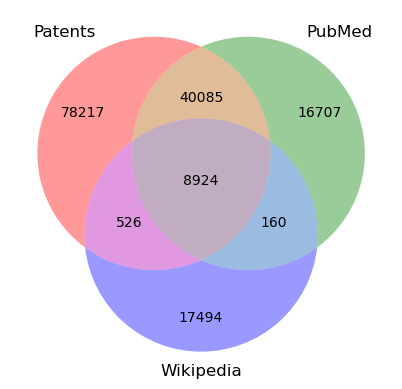

In [16]:
df = venn3_unweighted([patent_set,pmid_set, wiki_set],set_labels=("Patents","PubMed", "Wikipedia"))
plt.savefig("publications_venn.pdf",format="pdf", bbox_inches="tight")

In [17]:
numchem = len(patent_set | pmid_set | wiki_set)
print("Total chemicals in publications:", numchem)
print("Unique INCHIKeys:", len(ik_set), len(ik_orig_set), len(ik_full_set))
numchem/len(ik_full_set)*100

Total chemicals in publications: 162113
Unique INCHIKeys: 388661 388264 391710


41.385974317735055

In [19]:
pmid_counts.slice(0,10)

pyarrow.Table
cid: int64
inchi_key: string
pmid_count: int64
pmid_count_distinct: int64
----
cid: [[702,5997,962,977,24749,5283629,5957,6057,681,5202]]
inchi_key: [["LFQSCWFLJHTTHZ-UHFFFAOYSA-N","HVYWMOMLDIMFJA-DPAQBDIFSA-N","XLYOFNOQVPJJNP-UHFFFAOYSA-N","MYMOFIZGZYHOMD-UHFFFAOYSA-N","GZCGUPFRVQAUEE-UHFFFAOYSA-N","HVYWMOMLDIMFJA-VEIPTCAHSA-N","ZKHQWZAMYRWXGA-KQYNXXCUSA-N","OUYCCCASQSFEME-QMMMGPOBSA-N","VYFYYTLLBUKUHU-UHFFFAOYSA-N","QZAYGJVTTNCVMB-UHFFFAOYSA-N"]]
pmid_count: [[258046,221327,190235,179111,178556,127007,139762,122575,125887,116498]]
pmid_count_distinct: [[233597,193424,190208,178975,178554,127007,116448,109502,107112,103262]]

In [20]:
patent_counts.slice(0,10)

pyarrow.Table
cid: int64
inchi_key: string
patent_id_count: int64
----
cid: [[107428,453,6251,243,232,6101,24749,637517,6274,773]]
inchi_key: [["BJHIKXHVCXFQLS-PYWDMBMJSA-N","FBPFZTCFMRRESA-UHFFFAOYSA-N","FBPFZTCFMRRESA-KVTDHHQDSA-N","WPYMKLBDIGXBTP-UHFFFAOYSA-N","ODKSFYDXXFIFQN-UHFFFAOYSA-N","JOXIMZWYDAKGHI-UHFFFAOYSA-N","GZCGUPFRVQAUEE-UHFFFAOYSA-N","ZQPPMHVWECSIRJ-MDZDMXLPSA-N","HNDVDQJCIGZPNO-YFKPBYRVSA-N","HNDVDQJCIGZPNO-UHFFFAOYSA-N"]]
patent_id_count: [[680997,638068,592031,525252,509079,464982,461797,426432,418795,414130]]

In [22]:
wiki_counts.slice(0,10)

pyarrow.Table
cid: int64
pageviews: int64
months: int64
references: int64
average_pageviews: float
----
cid: [[3345,1615,446220,10836,33741,3446,5761,962,2118,3016]]
pageviews: [[19177140,16909463,16872919,15409582,15361905,14378961,13920072,13685406,13376273,12764238]]
months: [[94,94,94,94,94,94,94,94,94,94]]
references: [[1,1,1,1,1,1,1,1,1,1]]
average_pageviews: [[204012.12,179887.9,179499.14,163931.72,163424.52,152967.67,148085.88,145589.42,142300.78,135789.77]]

In [58]:
import requests
top_n = 10
all_counts = [ 
    ("Wikipedia Pageviews", wiki_counts, 'average_pageviews'),
    ("PubMed Articles", pmid_counts, 'pmid_count_distinct'),
    ("Patent IDs", patent_counts, 'patent_id_count'),
]
with requests.Session() as s:
    datasets = {}
    for cTuple in all_counts:
        source = cTuple[0]
        val_column = cTuple[2]
        #print(source, val_column)
        data = []
        for cid, value in zip(cTuple[1].slice(0,top_n)['cid'], cTuple[1][val_column]):
            pubchem_rest = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/description/JSON'
            r = s.get(pubchem_rest, timeout=5)
            r.raise_for_status()
            title = r.json()['InformationList']["Information"][0]["Title"]
            #print(cid, title, value)
            data.append((title, value))
        datasets[source] = data
        #print()
dsk = list(datasets.keys())
print(f"Compound & \\textbf{{{dsk[0]}}} & Compound & \\textbf{{{dsk[1]}}} & Compound & \\textbf{{{dsk[2]}}} \\\\")
print("\\hline")
for row in zip(*datasets.values()):
    first = True
    for pair in row:
        if first:
            print(f"{pair[0]} & {int(pair[1].as_py()):,} ", end="")
            first = False
        else:
            print(f"& {pair[0]} & {int(pair[1].as_py()):,} ", end="")
    print("\\\\")

Compound & \textbf{Wikipedia Pageviews} & Compound & \textbf{PubMed Articles} & Compound & \textbf{Patent IDs} \\
\hline
Fentanyl & 204,012 & Ethanol & 233,597 & D-sorbose & 680,997 \\
3,4-Methylenedioxymethamphetamine & 179,887 & Cholesterol & 193,424 & Hexitol & 638,068 \\
Cocaine & 179,499 & Water & 190,208 & Mannitol & 592,031 \\
Methamphetamine & 163,931 & Oxygen & 178,975 & Benzoic Acid & 525,252 \\
Tramadol & 163,424 & Mannose, D- & 178,554 & DL-Arginine & 509,079 \\
Gabapentin & 152,967 & Epicholesterol & 127,007 & p-Toluenesulfonic acid & 464,982 \\
Lysergide & 148,085 & Adenosine-5'-triphosphate & 116,448 & Mannose, D- & 461,797 \\
Water & 145,589 & Tyrosine & 109,502 & Elaidic Acid & 426,432 \\
Alprazolam & 142,300 & Dopamine & 107,112 & Histidine & 418,795 \\
Diazepam & 135,789 & Serotonin & 103,262 & DL-Histidine & 414,130 \\


In [57]:
dsk = list(datasets.keys())
print(f"Compound & \\textbf{{{dsk[0]}}} & Compound & \\textbf{{{dsk[1]}}} & Compound & \\textbf{{{dsk[2]}}} \\\\")
print("\\hline")
for row in zip(*datasets.values()):
    first = True
    for pair in row:
        if first:
            print(f"{pair[0]} & {int(pair[1].as_py()):,} ", end="")
            first = False
        else:
            print(f"& {pair[0]} & {int(pair[1].as_py()):,} ", end="")
    print("\\\\")

Compound & \textbf{PubMed Articles} & Compound & \textbf{Patent IDs} & Compound & \textbf{Wikipedia Pageviews} \\
\hline
Ethanol & 233,597 & D-sorbose & 680,997 & Fentanyl & 204,012 \\
Cholesterol & 193,424 & Hexitol & 638,068 & 3,4-Methylenedioxymethamphetamine & 179,887 \\
Water & 190,208 & Mannitol & 592,031 & Cocaine & 179,499 \\
Oxygen & 178,975 & Benzoic Acid & 525,252 & Methamphetamine & 163,931 \\
Mannose, D- & 178,554 & DL-Arginine & 509,079 & Tramadol & 163,424 \\
Epicholesterol & 127,007 & p-Toluenesulfonic acid & 464,982 & Gabapentin & 152,967 \\
Adenosine-5'-triphosphate & 116,448 & Mannose, D- & 461,797 & Lysergide & 148,085 \\
Tyrosine & 109,502 & Elaidic Acid & 426,432 & Water & 145,589 \\
Dopamine & 107,112 & Histidine & 418,795 & Alprazolam & 142,300 \\
Serotonin & 103,262 & DL-Histidine & 414,130 & Diazepam & 135,789 \\


In [44]:
type(list(dsk))

list